# 03b - BigQuery ML (BQML) - Boosted Trees For Classification

In this notebook, BigQuery ML (BQML) is used to create a boosted tree model (using XGBoost).

BigQuery has a number of machine learning algorithms callable directly from SQL.  This gives the convenience of using the common language of `SQL` with statments like `CREATE MODEL …`.  The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning.  A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey).

**Prerequisites:**
-  01 - BigQuery - Table Data Source

**Resources:**
-  [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
-  [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)

**Conceptual Flow & Workflow**
<p align="center">
  <img alt="Conceptual Flow" src="../architectures/slides/03b_arch.png" width="45%">
&nbsp; &nbsp; &nbsp; &nbsp;
  <img alt="Workflow" src="../architectures/slides/03b_console.png" width="45%">
</p>

---
## Setup

inputs:

In [64]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'google.com:cbo-mnl'

In [65]:
REGION = 'us-central1'
EXPERIMENT = '03b'
SERIES = '03'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# Resources for serving BigQuery Model Exports
TF_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
XGB_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [66]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt

clients:

In [67]:
bq = bigquery.Client()
aiplatform.init(project=PROJECT_ID, location=REGION)

parameters:

In [68]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

# Override the Bucket information below
BUCKET = 'jonas-ai-experiment'
URI = f"gs://{BUCKET}/{BQ_DATASET}/models/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

BQ_MODEL = f'{EXPERIMENT}_{BQ_DATASET}_{TIMESTAMP}'

---
## This Run

In [69]:
print(f'This run with create BQML model: {BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
print(f'The Timestamp Is: {TIMESTAMP}')

This run with create BQML model: google.com:cbo-mnl.fraud.03b_fraud_20221003095941
The Timestamp Is: 20221003095941


---
## Train Model

Use BigQuery ML to train multiclass boosted tree model using XGBoost:
- [Boosted Tree](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign training data for `FALSE` values and evaluation data for `TRUE` values.
    - in this example the `WHERE splits != 'TEST'` statement filters out the test data and
    - the `CASE` statement maps training data to FALSE and validation data to TRUE

In [147]:
query = f"""
CREATE MODEL IF NOT EXISTS `{BQ_DATASET}.{BQ_MODEL}`
OPTIONS
    (model_type = 'BOOSTED_TREE_CLASSIFIER',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        booster_type = 'GBTREE',
        num_parallel_tree = 1,
        max_iterations = 30,
        early_stop = TRUE,
        min_rel_progress = 0.01,
        tree_method = 'HIST',
        subsample = 0.85
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE splits != 'TEST'
"""
job = bq.query(query = query)
job.result()

In [109]:
(job.ended-job.started).total_seconds()

0.188

Add labels to the model in BigQuery:

In [110]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

Review the iterations from training with [`ML.TRAINING_INFO`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [111]:
history = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        ORDER BY iteration"""
).to_dataframe()
history

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,0.460507,0.479036,0.3,102702
1,0,2,0.329981,0.361516,0.3,76
2,0,3,0.241684,0.280263,0.3,116
3,0,4,0.180250,0.232672,0.3,96
4,0,5,0.137056,0.207064,0.3,74
5,0,6,0.105203,0.196465,0.3,81
6,0,7,0.083279,0.188607,0.3,77
7,0,8,0.065707,0.181996,0.3,172
8,0,9,0.053424,0.178882,0.3,90
9,0,10,0.044077,0.174768,0.3,81


Plot the loss history:

<AxesSubplot:xlabel='iteration'>

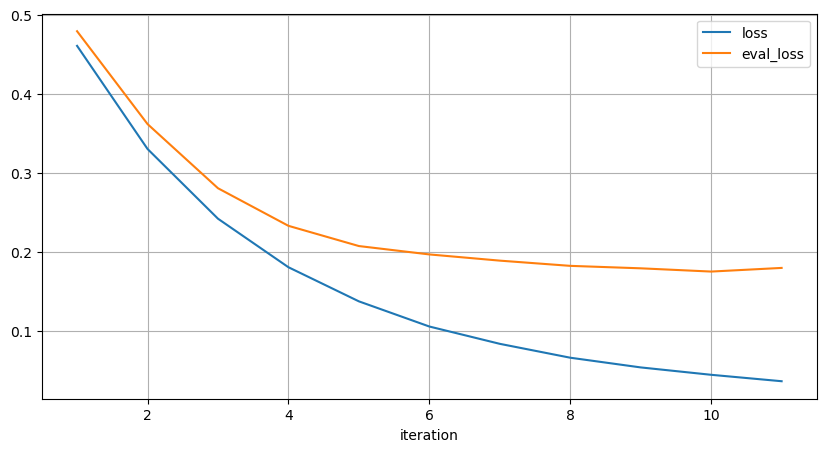

In [112]:
history.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [113]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=google.com:cbo-mnl


In [114]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=google.com:cbo-mnl&ws=!1m5!1m4!5m3!1sgoogle.com:cbo-mnl!2sfraud!3s03b_fraud_20221003095941


---
## Evaluate Model

### Metrics

Review the model evaluation statistics on the splits with [`ML.EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [115]:
query = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TRAIN'))
"""
bq.query(query = query).to_dataframe()

,SPLIT,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,VALIDATE,0.479339,0.892308,0.997561,0.623656,0.033593,0.970735
1,TEST,0.494118,0.823529,0.998181,0.617647,0.032679,0.981502
2,TRAIN,0.492147,1.000000,0.998295,0.659649,0.032488,1.000000


### Confusion Matrix

Review the confusion matrix for each split with [`ML.CONFUSION_MATRIX`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion):

In [116]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,226753,388
1,1,0,376


In [117]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,28575,63
1,1,7,58


In [118]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
bq.query(query = query).to_dataframe()

,expected_label,_0,_1
0,0,28493,43
1,1,9,42


### ROC Curve

Retrieve the ROC Curve for each split using [`ML.ROC_CURVE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc):

In [119]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
train_roc = bq.query(query = query).to_dataframe()
train_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.017167,1.0,0.760008,376,172629,54512,0
1,0.017450,1.0,0.699667,376,158923,68218,0
2,0.018067,1.0,0.619355,376,140681,86460,0
3,0.022910,1.0,0.348907,376,79251,147890,0
4,0.026360,1.0,0.258910,376,58809,168332,0


In [120]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
val_roc = bq.query(query = query).to_dataframe()
val_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.016687,0.984615,0.900517,64,25789,2849,1
1,0.016875,0.984615,0.841434,64,24097,4541,1
2,0.026050,0.969231,0.268559,63,7691,20947,2
3,0.018007,0.969231,0.629374,63,18024,10614,2
4,0.220711,0.923077,0.008101,60,232,28406,5


In [121]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
test_roc = bq.query(query = query).to_dataframe()
test_roc.head()

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.016672,1.0,0.920031,51,26254,2282,0
1,0.016875,1.0,0.842830,51,24051,4485,0
2,0.016450,1.0,0.960226,51,27401,1135,0
3,0.017449,1.0,0.699748,51,19968,8568,0
4,0.016310,1.0,0.970143,51,27684,852,0


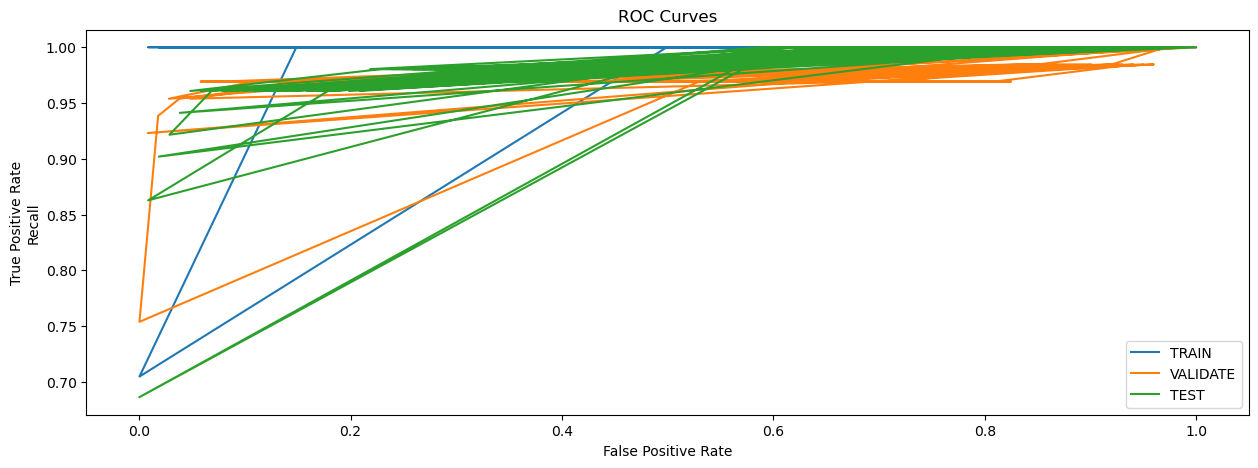

In [122]:
plt.figure(figsize=(15,5))
plt.plot(train_roc['false_positive_rate'], train_roc['recall'], label='TRAIN')
plt.plot(val_roc['false_positive_rate'], val_roc['recall'], label='VALIDATE')
plt.plot(test_roc['false_positive_rate'], test_roc['recall'], label='TEST')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate\nRecall')
plt.title('ROC Curves')
plt.legend()
plt.show()

---
## Predictions

Create a pandas dataframe with predictions for the test data in the table:

In [123]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

Review columns from the predictions - note that the query added columns with prefix `predicted_`

In [124]:
pred.columns

Index(['predicted_Class', 'predicted_Class_probs', 'Time', 'V1', 'V2', 'V3',
       'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14',
       'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24',
       'V25', 'V26', 'V27', 'V28', 'Amount', 'Class', 'transaction_id',
       'splits'],
      dtype='object')

Print the first few rows for the columns related to the actual and predicted values:

In [125]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'splits']].head()

,Class,predicted_Class,predicted_Class_probs,splits
0,0,0,"[{'label': 1, 'prob': 0.21381093561649323}, {'...",TEST
1,0,0,"[{'label': 1, 'prob': 0.4882608950138092}, {'l...",TEST
2,0,0,"[{'label': 1, 'prob': 0.020372722297906876}, {...",TEST
3,0,0,"[{'label': 1, 'prob': 0.018331710249185562}, {...",TEST
4,0,0,"[{'label': 1, 'prob': 0.02550594136118889}, {'...",TEST


Notice the nested dictionary for predicted probabilities.  In BigQuery this is a Record type structure with nested fields for `label` and `prop`.  This is returned to the pandas dataframe as a nested dictionary.

The following code sorts the dictionary for the first record by `prob`:

In [126]:
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')
[sorted(x, key = lambda x: x['label']) for x in [temp]]

[[{'label': 0, 'prob': 0.7861890196800232},
  {'label': 1, 'prob': 0.21381093561649323}]]

---
## Explanations
[Built-in](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview) capabilities to understand how features contributed to predictions both individually (local) and overall (global).

### Local Explainability
Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [`ML.EXPLAIN_PREDICT`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [127]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bq.query(query = query).to_dataframe()

In [128]:
explain.head()

,predicted_Class,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,Time,V1,V2,V3,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,0,0.786189,"[{'feature': 'V14', 'attribution': 0.962515473...",0.436061,1.336350,0.0,5043,-0.610353,0.876268,3.134572,...,-0.183132,0.295979,-0.159989,-0.130196,-0.076139,-0.109076,0.0,0,c53a0939-4986-4db8-bf1b-1b8a5d66a495,TEST
1,0,0.511739,"[{'feature': 'V14', 'attribution': 1.182693719...",0.436061,0.693759,0.0,8785,1.153022,0.436133,1.274728,...,0.054247,0.441790,0.144198,0.995412,-0.057928,0.011057,0.0,0,31c6a284-bf4e-4fe1-a6a5-54e814db9049,TEST
2,0,0.979627,"[{'feature': 'V14', 'attribution': 1.034089207...",0.436061,2.540792,0.0,47284,1.083086,-0.351338,1.128419,...,0.014244,-0.240059,0.120230,0.618435,0.029500,0.003249,0.0,0,80849f70-e097-4769-ba15-bb77a323de47,TEST
3,0,0.981668,"[{'feature': 'V14', 'attribution': 0.913889288...",0.436061,2.363547,0.0,49582,1.069103,-0.040292,1.437476,...,-0.078798,0.084000,0.487789,0.248265,0.054261,0.019949,0.0,0,3e86637b-a1c9-475d-8a45-75627b3141f0,TEST
4,0,0.974494,"[{'feature': 'V14', 'attribution': 1.169145822...",0.436061,2.609827,0.0,78048,-6.484267,-7.875117,0.680973,...,-0.041943,-0.246966,-0.745300,0.195860,0.166256,-1.216419,0.0,0,8bf45536-66ba-43c0-b1cc-0bf14731dd37,TEST


Create a plot of feature attributions for a single prediction:

In [129]:
explanation = explain.iloc[0]['top_feature_attributions']

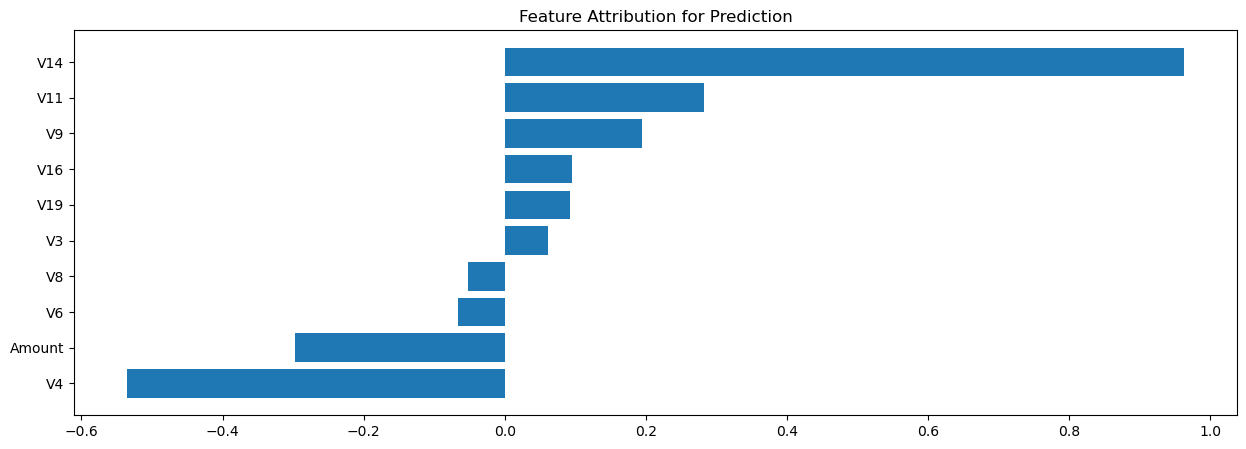

In [130]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title('Feature Attribution for Prediction')
plt.show()

### Global Explainability
Retrieve the influence of each feature on the model with [`ML.GLOBAL_EXPLAIN`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [131]:
query = f"""
SELECT *
FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
gexplain = bq.query(query = query).to_dataframe()

In [132]:
gexplain.head()

,feature,attribution
0,V14,0.812982
1,V4,0.261094
2,V12,0.239902
3,V1,0.153620
4,V11,0.145073


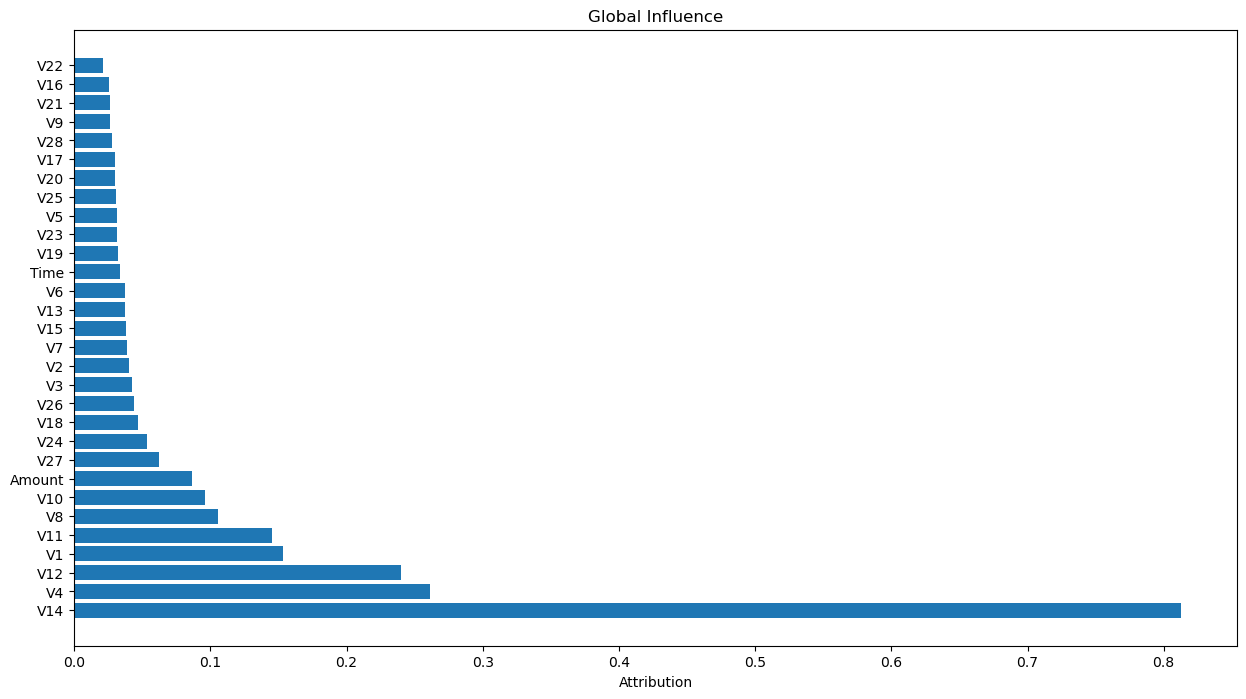

In [133]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

### Feature Importance

Retrieve the [XGBoost feature importances](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor.feature_importances_) for the model using [`ML.FEATURE_IMPORTANCE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-importance).
- importance_weight: the number of splits the feature was used in across all trees
- importance_gain: the improvement in accuracy due to splits using the feature
- importance_cover: the number of rows of data covered by splits using the feature

In [134]:
query = f"""
SELECT *
FROM ML.FEATURE_IMPORTANCE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
feature_importance = bq.query(query = query).to_dataframe()

In [135]:
feature_importance

,feature,importance_weight,importance_gain,importance_cover
0,Time,19,140.763452,2664.693238
1,V1,45,91.480598,9836.373319
2,V2,9,115.998142,1207.547990
3,V3,28,132.011270,3846.402435
4,V4,72,421.676745,10591.001968
5,V5,4,93.150818,1335.561647
6,V6,13,127.909059,4365.155642
7,V7,35,191.567606,7408.781072
8,V8,39,248.362778,4333.483038
9,V9,13,165.451868,1338.758445


---
## Serving With Vertex AI

This demonstration shows the process of exporting and registering a BQML model with Vertex AI Model Registry.  To directly integrate BQML with Vertex AI Model Registry it is now (April 1, 2022) possible at model creation time with options `vertex_ai_model_id` and `vertex_ai_model_version_alises`. See the documentation for this direct integration [here](https://cloud.google.com/bigquery-ml/docs/managing-models-vertex).

### Export the BigQuery Model

Reference: [Export the BigQuery Model](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [136]:
query = f"""
EXPORT MODEL `{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = '{URI}/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [137]:
(export.ended - export.started).total_seconds()

1.489

In [138]:
listing = !gsutil ls {URI}/{TIMESTAMP}/model
listing

['gs://jonas-ai-experiment/fraud/models/03/03b/20221003095941/model/main.py',
 'gs://jonas-ai-experiment/fraud/models/03/03b/20221003095941/model/model.bst',
 'gs://jonas-ai-experiment/fraud/models/03/03b/20221003095941/model/xgboost_predictor-0.1.tar.gz',
 'gs://jonas-ai-experiment/fraud/models/03/03b/20221003095941/model/assets/']

In [139]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{URI.split('//')[-1]}/{TIMESTAMP}/model?project={PROJECT_ID}")

View the export in the console:
https://console.cloud.google.com/storage/browser/jonas-ai-experiment/fraud/models/03/03b/20221003095941/model?project=google.com:cbo-mnl


### Detect The Model Types Framework

In [140]:
filetype = {'pb': 'TensorFlow', 'bst': 'XGBoost'}

filetypes = [filetype[f.split('.')[-1]] for f in listing if f.split('.')[-1] in ['pb','bst']]
if len(filetypes) == 1:
    framework = filetypes[0]
    print(f'framework = {framework}')
else:
    raise TypeError(f"Model Type Undeteremined!! Review the contents of of 'listing = {listing}'.")

framework = XGBoost


Set the `DEPLOY_IMAGE` based on the framework:

In [141]:
if framework == 'TensorFlow':
    DEPLOY_IMAGE = TF_DEPLOY_IMAGE
elif framework == 'XGBoost':
    DEPLOY_IMAGE = XGB_DEPLOY_IMAGE
    
DEPLOY_IMAGE

'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

### Upload The Model To Vertex AI Model Registry
References:
- Python SDK for [`aiplatform.Model`](https://googleapis.dev/python/aiplatform/latest/aiplatform/services.html#google.cloud.aiplatform.Model)
- Python Client for [`aiplatform.Model`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [142]:
modelmatch = aiplatform.Model.list(filter = f'labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        upload_model = False
        model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        parent_model =  modelmatch[0].resource_name
else:
    print('This is a new model, adding to model registry as version 1')
    parent_model = ''

if upload_model:
    model = aiplatform.Model.upload(
        display_name = f'{EXPERIMENT}_{BQ_DATASET}',
        model_id = f'model_{EXPERIMENT}_{BQ_DATASET}',
        parent_model = parent_model,
        serving_container_image_uri = DEPLOY_IMAGE,
        artifact_uri = f"{URI}/{TIMESTAMP}/model",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}', 'timestamp': f'{TIMESTAMP}', 'run_name' : f'{RUN_NAME}', 'framework' : f'{framework.lower()}'}
    )  

Model Already in Registry:
This version already loaded, no action taken.


In [143]:
model.display_name

'03b_fraud'

In [144]:
model.resource_name

'projects/169853841455/locations/us-central1/models/model_03b_fraud'

In [145]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/model_{EXPERIMENT}_{BQ_DATASET}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_03b_fraud?project=google.com:cbo-mnl


---
## Online Predictions with Vertex AI Endpoints
Check out the notebook `03Tools - Predictions` to see how to use this model with [online predictions in Vertex AI](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models).

---
## Remove Resources
see notebook "99 - Cleanup"